# An example of executing the HDC program for the Yeast Cell Cycle data

## Preliminary processing 

For this example code, the following packages are needed for functions to be correctly called: 
igraph, coin, ks, dynamicTreeCut, GOstats, org.Sc.sgd.db (for this specific dataset)

### Set paths and Load in source files

In [96]:
setwd("C:/...")
filepath <- "C:/..."
dyn.load(paste0(filepath, "csupp.dll")) ## for Windows only
source(paste0(filepath,"utils.r"))
source(paste0(filepath,"visualize.r")) 

### Load in data
Only use 1000 rows (genes) as demonstration

In [3]:
load('spellman_73_filled.bin')
load("GO_select_yeast_ 0.7 0.4 1000 20 .bin")
array = array[sample(nrow(array), 1000),]
dim(array)

[1] 1000   77

### Delete samples with >10% samples and normalize each gene

In [4]:
dat <- deleteZeros(array)
dat <- normalizeData(dat)

Loading required package: survival


Recording:

In [5]:
nog=nrow(dat) ## number of genes
nos=ncol(dat) ## number of samples
glist=rownames(dat) ## gene name list
clist=colnames(dat) ## sample name list
rownames(dat)=1:nog ## re-name genes as numbers
colnames(dat)=NULL

## Quantifying the ternary relationship &
## Selecting significant triplets using permutation and mixture models

### Thresholds for pairwise correlations

In [6]:
corr=cor(t(dat))  ## pairwise correlation matrix
dict <- penalizeCorr(corr)  ## "dictionary" for low correlated pairs
diag(dict)=0

Correlation thresholds: -0.1787083 0.2120516 


### Triplets selection 
This is the most time consuming step

In [7]:
triplets <- makeTriplets(nog, nos, dat, dict, fdr=0.2) 
dim(triplets)


Attaching package: 'ks'

The following object is masked from 'package:igraph':

    compare



Number of triplets: 13 .    *** Gene  200  calculated. ***
Number of triplets: 21 .    *** Gene  400  calculated. ***
Number of triplets: 14 .    *** Gene  500  calculated. ***
Number of triplets: 2 .    *** Gene  900  calculated. ***
Number of triplets: 17 .    *** Gene  1000  calculated. ***

**** Finished calculating assigned genes. ****


## Selecting gene modules using supervised and unsupervised approaches &
## Constructing the module-level hypergraph

### Unsupervised approaches

In [8]:
A <- createFlow(triplets, nog, corMat=FALSE) ## usually don't calculate corMat here
glist_new <- which(apply(A,2,sum)!=0)
cat(length(glist_new),"out of", dim(A)[1],".\n")
corA <- cor(A[glist_new,glist_new]) ## calculate the correlation matrix for A here
label_sub <- createLabels_unsup(1-corA) 
label <- matrix(0,ncol=ncol(label_sub),nrow=nrow(A))
label[glist_new,] <- label_sub

955 out of 1000 .
 ..cutHeight not given, setting it to 0.991  ===>  99% of the (truncated) height range in dendro.
 ..Going through the merge tree
 
 ..Going through detected branches and marking clusters..
 ..Assigning Tree Cut stage labels..
 ..done.
Number of clusters:  15 


#### Module level hyper-network

In [9]:
noc=ncol(label)-1 ## num of clusters
labelSum <- apply(label[,1:noc],2,sum)
net_vec<-shrink(triplets,label)
fullNet_vec<-fullyConnect(labelSum)
net<-normalize(noc,net_vec,fullNet_vec)
r=sum(as.numeric(net_vec))/sum(as.numeric(fullNet_vec))
net <- net/r
net <- array(net,c(noc,noc,noc))

#### Enrichment analysis

In [10]:
enrichment <- GOen(glist,label) 
enrichment

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following object is masked _by_ '.GlobalEnv':

    normalize

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:igraph':

    normalize, path, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMea

1 out of 15 done.
2 out of 15 done.
3 out of 15 done.
4 out of 15 done.
5 out of 15 done.
6 out of 15 done.
7 out of 15 done.


Warning message:
"No results met the specified criteria.  Returning 0-row data.frame"

8 out of 15 done.
9 out of 15 done.
10 out of 15 done.
11 out of 15 done.
12 out of 15 done.
13 out of 15 done.
14 out of 15 done.


Warning message:
"No results met the specified criteria.  Returning 0-row data.frame"

15 out of 15 done.


,GOBPID,Pvalue,OddsRatio,ExpCount,Count,Size,Term
1,GO:0071470,0.0001969133,22.638889,0.7291667,5,7,cellular response to osmotic stress
2,GO:0016311,0.0006732755,5.687003,2.1875000,8,21,dephosphorylation
3,GO:0006970,0.0010270223,7.800963,1.3541667,6,13,response to osmotic stress
5,GO:0071214,0.0018264466,9.022222,1.0416667,5,10,cellular response to abiotic stimulus
6,GO:0104004,0.0018264466,9.022222,1.0416667,5,10,cellular response to environmental stimulus
7,GO:0048585,0.0030740386,7.509259,1.1458333,5,11,negative regulation of response to stimulus
11,GO:1902531,0.0072210113,5.618056,1.3541667,5,13,regulation of intracellular signal transduction
12,GO:0033554,0.0089160988,2.051064,11.8750000,20,114,cellular response to stress
13,GO:0000165,0.0093837270,13.288043,0.5208333,3,5,MAPK cascade
14,GO:0000209,0.0093837270,13.288043,0.5208333,3,5,protein polyubiquitination


#### Visualization

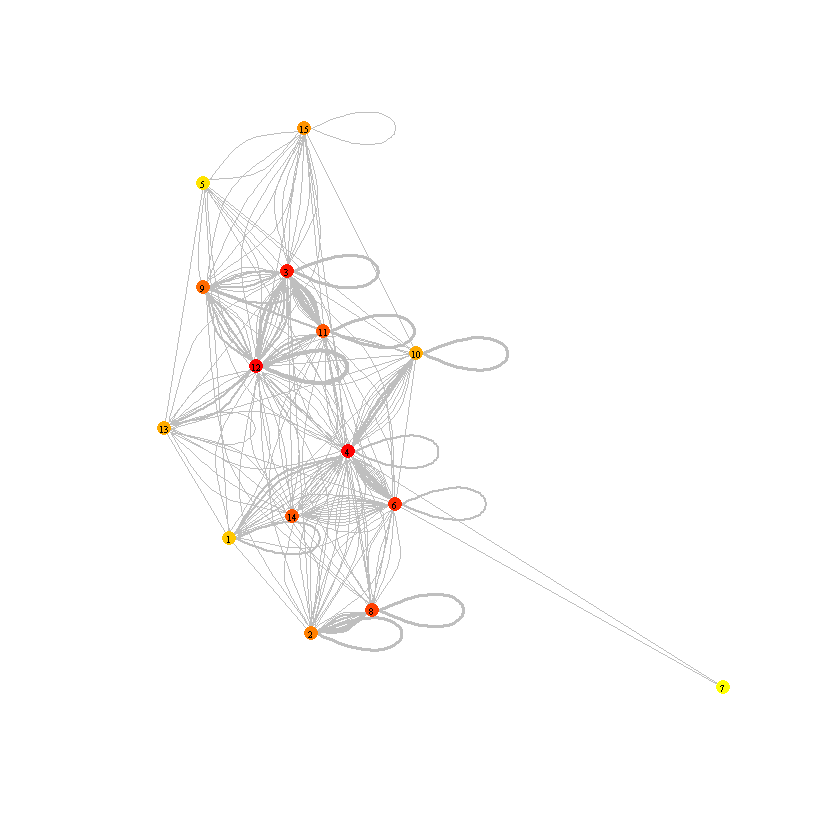

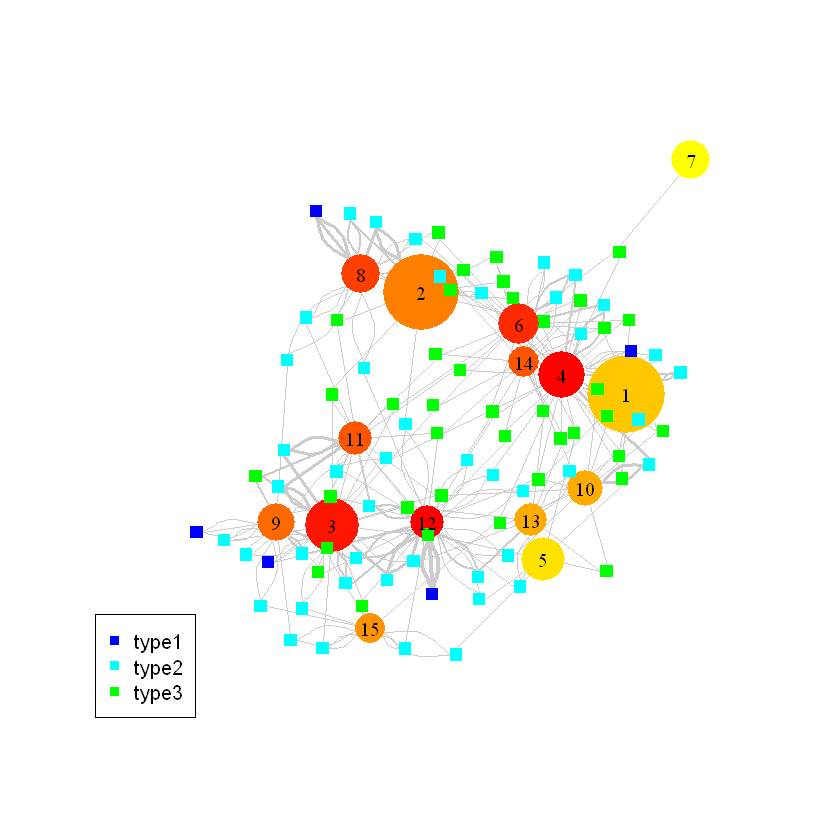

In [14]:
full_hypergraph <- plot_entrie_unsup(net, label, folds=2)
plot_top_unsup(full_hypergraph$g, full_hypergraph$elist, full_hypergraph$folds)

### Supervised approaches

In [15]:
label <- createLabels_sup(GO.select, glist)

#### Module level hyper-network

In [16]:
noc=ncol(label)-1 ## num of clusters
labelSum=apply(label[,1:noc],2,sum)
net_vec<-shrink(triplets,label)
fullNet_vec<-fullyConnect(labelSum)
net<-normalize(noc,net_vec,fullNet_vec)
r <- sum(as.numeric(net_vec))/sum(as.numeric(fullNet_vec))
net <- net/r
net <- array(net,c(noc,noc,noc))

#### Visualization 
The third hypergraph plot is centered at an example GO term 

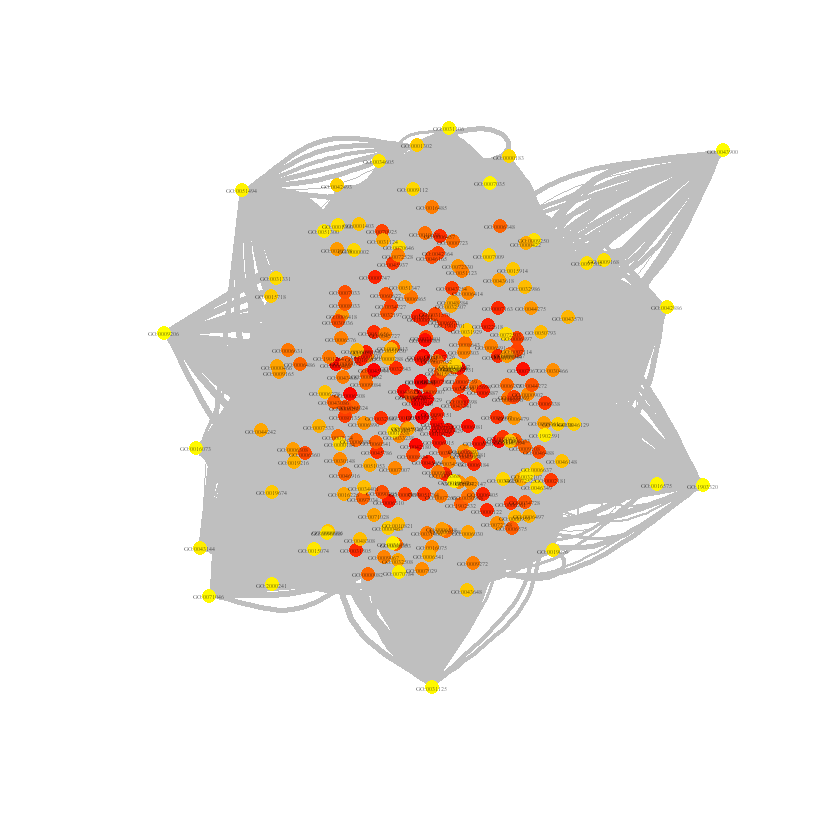

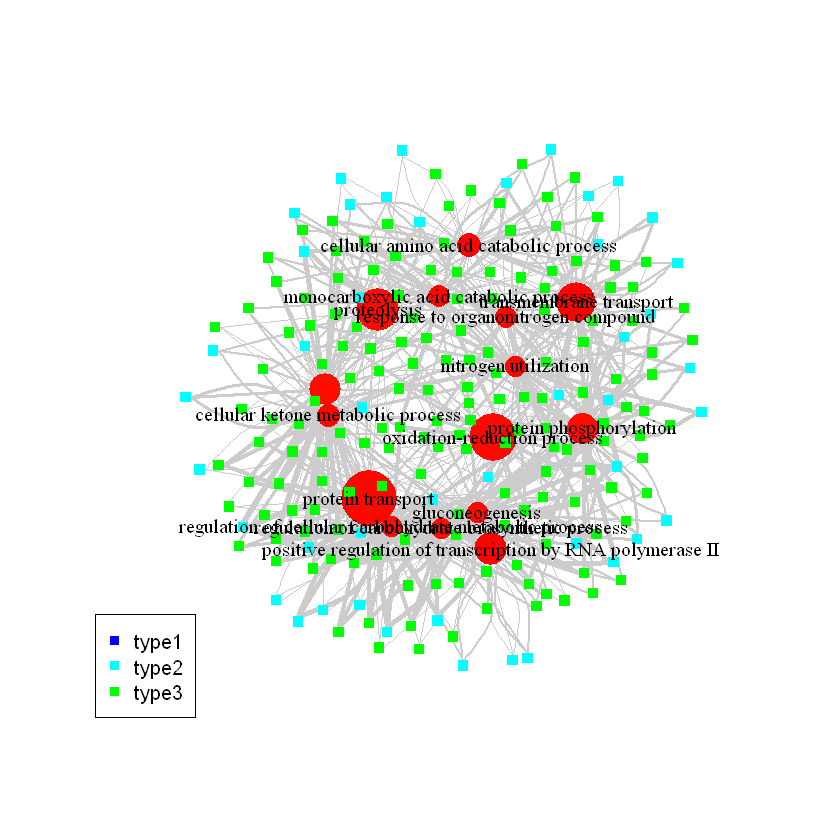

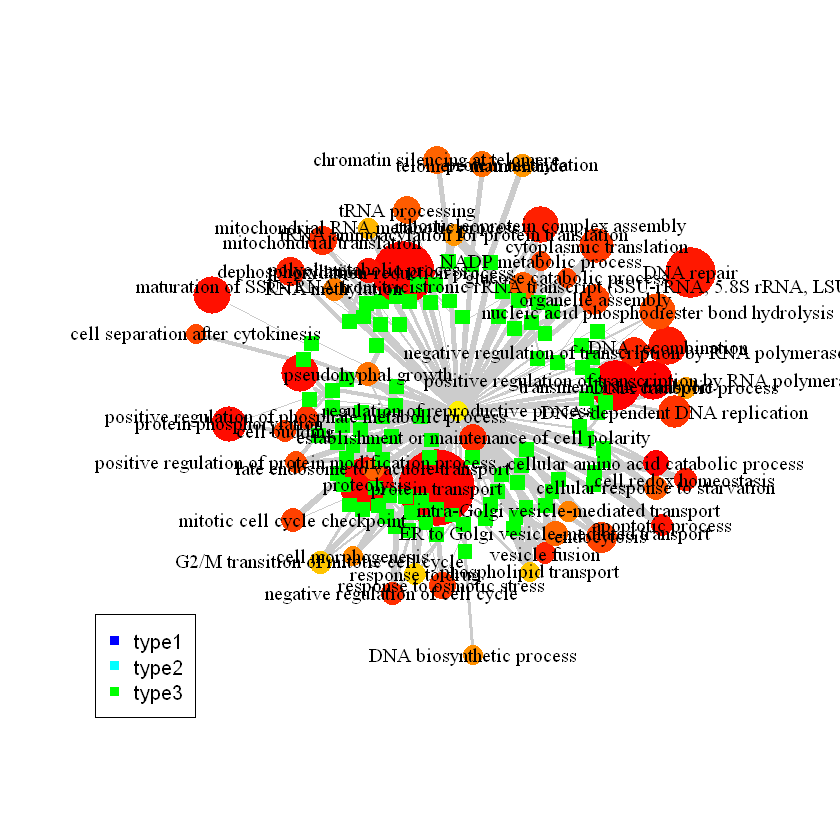

In [17]:
full_hypergraph <- plot_entrie_sup(net, label, GO.select, folds=5)
plot_top_sup(full_hypergraph$g, full_hypergraph$elist, GO.select, full_hypergraph$folds)
plot_one_sup(full_hypergraph$g, full_hypergraph$elist, GO.select, full_hypergraph$folds, "GO:2000241")


#### Plot gene level hypergraph for a given module level hyper-edge
Suppose we are interested in the hyperedge among GO:0000747, GO:0007126, and GO:0055085.

In [95]:
GO <- names(GO.select)
module_names <- Term(GO)
which(GO=="GO:0000747")
which(GO=="GO:0007126")
which(GO=="GO:0045454")
hyperedge <- c(7, 9, 34)

[1] 7

[1] 9

[1] 34

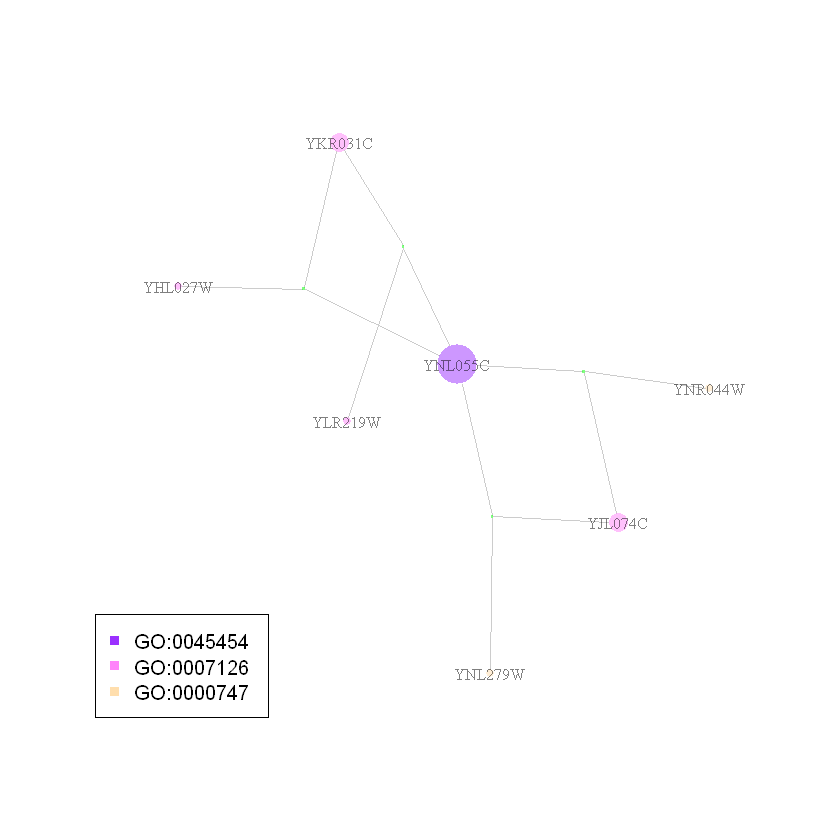

In [99]:
plot_gene_level(hyperedge, GO, net, label, triplets, glist, folds=5)